In [33]:
import os
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
from collections import defaultdict
import seaborn as sns
import pandas as pd
# from scipy.stats import pearsonr
import pickle
from sklearn.utils import resample
import json

sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'


In [132]:
# Define directory paths
# directory_path = '../Sequencing_data_20230831/rep2/'
directory_path = './dNAC_1/'

Genome_path = 'Genome_information/'

# Define groups
group1, group2 = 'p1', 'p2'

# Load HDF5 files
p1 = h5py.File(f"{directory_path}p1_count/cds_umi_psite.h5", 'r')
p2 = h5py.File(f"{directory_path}p2_count/cds_umi_psite.h5", 'r')

# Function to calculate total counts and save them to a file
def calculate_total_counts(group, file_handle):
    output_file = f"{directory_path}{group}_count_reads"
    
    # Check if the file exists and load the total counts directly
    if os.path.exists(output_file):
        with open(output_file, 'r') as inFile:
            total_counts = int(float(inFile.readline().strip()))
            print(f"Loaded total reads for {group}: {total_counts}")
            return total_counts
    
    # Calculate total counts if the file doesn't exist
    total_counts = sum(sum(file_handle[gene][1]) for gene in file_handle.keys())
    
    with open(output_file, 'w') as outFile:
        outFile.write(str(total_counts))
    
    print(f"Calculated and saved total reads for {group}: {total_counts}")
    return total_counts

# Compute total reads
p1_Total_Reads = calculate_total_counts('p1', p1)
p2_Total_Reads = calculate_total_counts('p2', p2)

Loaded total reads for p1: 0
Loaded total reads for p2: 0


In [133]:

# Function to convert nucleotide-level reads to codon-level reads
def nt_to_codon(group, gene):
    p = p1 if group == group1 else p2
    codon_dict = defaultdict(int)

    for index, nt_position in enumerate(p[gene][0].tolist()):
        codon_idx = math.ceil(nt_position / 3)
        codon_dict[codon_idx] += p[gene][1][index]

    return codon_dict

# Function to process gene trace
def gene_trace(group, gene):
    Reads, p = (p1_Total_Reads, p1) if group == group1 else (p2_Total_Reads, p2)
    codon_length = int(p[gene].attrs['cds_length']) // 3
    Dict_c = nt_to_codon(group, gene)
    
    window, flank = 15, 7  # Adjusted flank calculation for clarity

    # Normalize codon reads
    Dict_c = {k: 0.05 + (Dict_c.get(k, 0) / Reads * 1e6) for k in range(1, codon_length + 1)}

    # Apply smoothing
    Dict_s = {}
    for i in range(1, codon_length + 1):
        start, end = max(1, i - flank), min(codon_length, i + flank)
        Dict_s[i] = sum(Dict_c[j] for j in range(start, end + 1)) / (end - start + 1)

    return sorted(Dict_s.items())

# Function to compute gene enrichment
def gene_enrichment(gene):
    List1, List2 = gene_trace('p1', gene), gene_trace('p2', gene)
    x1, y1 = zip(*List1)
    x2, y2 = zip(*List2)

    y3 = [(y2[i] / y1[i]) if y1[i] != 0 and y2[i] != 0 else np.nan for i in range(len(y1))]
    y4 = [0] * len(x1)

    return x1, y1, y2, y3, y4



In [134]:
# Function to plot gene enrichment
def plot_gene_enrichment(gene):
    x1, y1, y2, y3, y4 = gene_enrichment(gene)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 5), sharex=True)

    # Plot RPM values
    ax2.plot(x1, y1, color='black', linewidth=1)
    ax2.plot(x1, y2, color='darkred', linewidth=1)
    ax2.set_ylabel('RPM')
    ax2.legend(['Total', 'AP'], loc='upper left', prop={'size': 10})
    ax2.set_ylim(0,)

    # Plot enrichment values
    ax1.plot(x1, y3, color='black', linewidth=1)
    ax1.set_ylabel('Enrichment')
    ax1.set_ylim(0, )

    # Adjust aesthetics
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    legend=ax2.legend(['Total', 'AP'], loc='upper left',prop={'size':10})
    legend.get_frame().set_linewidth(0.0)
    ax1.set_xlim(1, len(x1))
    ax1.set_title(gene)
    ax2.set_xlabel('Codon/amino acids')

    plt.show()

plot_gene_enrichment('MARS2')


KeyError: "Unable to synchronously open object (object 'MARS2' doesn't exist)"

In [ ]:
# Load gene localization data
def load_gene_localization(file_path):
    df = pd.read_csv(file_path)
    return df.set_index('gene')['localization'].to_dict()

gene_localization = load_gene_localization(f"{Genome_path}human gene localization.csv")

# Calculate RPKM
def calculate_rpkm(count, total_reads, length):
    if total_reads == 0 or length == 0:
        return np.nan
    return (count / total_reads / length) * 1e9

# Process gene data
def process_gene_data(gene):
    if gene not in p1 or gene not in p2:
        return None

    p1_count = sum(p1[gene][1])
    p2_count = sum(p2[gene][1])
    length = int(p1[gene].attrs['cds_length'])
    codon_length = length // 3

    p1_RPKM = calculate_rpkm(p1_count, p1_Total_Reads, length)
    p2_RPKM = calculate_rpkm(p2_count, p2_Total_Reads, length)

    ratio = p2_RPKM / p1_RPKM if p1_RPKM > 0 else np.nan
    log2_ratio = np.log2(ratio) if ratio > 0 else np.nan

    p1_norm = p1_count / codon_length if codon_length > 0 else np.nan
    p2_norm = p2_count / codon_length if codon_length > 0 else np.nan

    return {
        'localization': gene_localization.get(gene, 'Unknown'),
        'Length': codon_length,
        f'{group1}_count': p1_count,
        f'{group2}_count': p2_count,
        f'{group1}_RPKM': p1_RPKM,
        f'{group2}_RPKM': p2_RPKM,
        'ratio': ratio,
        'Log2_ratio': log2_ratio,
        f'{group1}_norm': p1_norm,
        f'{group2}_norm': p2_norm
    }

# Generate gene enrichment dataframe
def generate_gene_enrichment_dataframe():
    gene_loc = {gene: data for gene in gene_localization if (data := process_gene_data(gene))}
    gene_loc_df = pd.DataFrame.from_dict(gene_loc, orient='index')
    gene_loc_df.index.name = 'gene'
    gene_loc_df = gene_loc_df.sort_values(by='ratio', ascending=False)
    gene_loc_df.to_csv(f"{directory_path}gene_enrichment_list.csv")
    return gene_loc_df

gene_loc_df = generate_gene_enrichment_dataframe()

# Apply threshold to filter genes
def filter_genes_by_threshold(df, threshold=50):
    filtered_df = df.loc[(df[f'{group1}_count'] >= threshold) & (df[f'{group2}_count'] >= threshold)]
    filtered_df.to_csv(f"{directory_path}gene_enrichment_list_threshold.csv")
    return filtered_df

filtered_gene_loc_df = filter_genes_by_threshold(gene_loc_df)

# Merge and save results
def merge_and_save(file_path, enrichment_file, output_file):
    df1 = pd.read_csv(enrichment_file)
    df2 = pd.read_csv(file_path)
    merged_df = pd.merge(df1, df2, on = 'gene', how='inner')
    merged_df.to_csv(output_file, index=False)

merge_and_save(f"{Genome_path}human_mitochondrial_proteins_MTS.csv",
                f"{directory_path}gene_enrichment_list.csv",
                f"{directory_path}Mito_gene_enrichment_list.csv")

merge_and_save(f"{Genome_path}APEX all annotation_uniprot.csv",
                f"{directory_path}gene_enrichment_list.csv",
                f"{directory_path}gene_enrichment_list_APEX.csv")


(0.5, 100000)

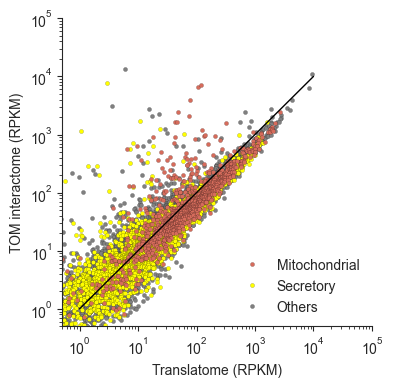

In [ ]:
data = pd.read_csv(directory_path + 'gene_enrichment_list.csv')
x_value = str(group1) + '_RPKM'
y_value = str(group2) + '_RPKM'

# Slice out x and y values
x = data[x_value]
y = data[y_value]

# data2 = data[data['Log2_ratio'] >= 1]
data2 = data


x_cyto = data2.loc[data2['localization'] == 'cytosol', x_value]
y_cyto = data2.loc[data2['localization'] == 'cytosol', y_value]

x_sec = data2.loc[data2['localization'] == 'secretome', x_value]
y_sec = data2.loc[data2['localization'] == 'secretome', y_value]

x_mito = data2.loc[data2['localization'] == 'mitochondria', x_value]
y_mito = data2.loc[data2['localization'] == 'mitochondria', y_value]

# pearson = round(pearsonr(x, y)[0],3)

plt.figure(figsize=(4, 4))

fig1 = plt.plot(x_cyto ,y_cyto, marker='o', color='grey',linestyle='none', markersize=3, mec = 'black', mew = 0.1)
fig2 = plt.plot(x_sec , y_sec, marker='o', color='yellow',linestyle='none', markersize=3, mec = 'black', mew = 0.1)
fig3 = plt.plot(x_mito , y_mito, marker='o', color='#D66C5C',linestyle='none', markersize=3, mec = 'black', mew = 0.1)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on")

legend=ax.legend((fig3 + fig2 + fig1), ['Mitochondrial', 'Secretory', 'Others'],prop={'size':10}, loc = 'lower right')
legend.get_frame().set_linewidth(0.0)

# # legend=plt.legend(["Pearson's r =" + str(pearson)], loc='lower right', prop={'size':10})

# plt.text(-1.5, 2.5, "$\mathregular{R^2}$ = " + str(pearson), fontsize=14, weight='bold')
plt.xlabel('Translatome (RPKM)',fontsize=10)
plt.ylabel('TOM interactome (RPKM)',fontsize=10)


plt.xscale('log')
plt.yscale('log')

plt.plot([1,10000],[1,10000],color='black',linewidth=1)
y_boundary=[]
x_boundary=[]
for i in range(1,10001):
    x_boundary.append(0.5*i)
x_boundary = np.array(x_boundary)  

# plt.plot(x_boundary, 2*x_boundary,color='black',linestyle='--',linewidth=1)
# plt.plot(x_boundary, 0.5*x_boundary,color='black',linestyle='--',linewidth=1)


# # Make nice y-limits
plt.ylim(0.5, 100000)
plt.xlim(0.5, 100000)
# plt.savefig(directory_path + 'TOM22_scatterplot_all.jpg', dpi=300, bbox_inches = 'tight')


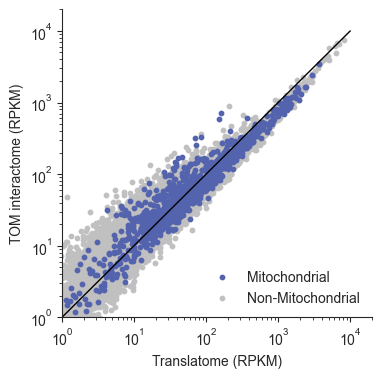

In [95]:
plt.figure(figsize=(4, 4))

mask = data['localization'] != 'mitochondria'
color = 'silver'
fig1 = plt.scatter(data[mask][x_value], data[mask][y_value], color=color, alpha=1, edgecolor=color, s=10)
mask = data['localization'] == 'mitochondria'
color = '#5463ad'
fig2 = plt.scatter(data[mask][x_value], data[mask][y_value], color=color, alpha=1, edgecolor=color, s=10)

# x_cyto = data2.loc[data2['localization'] != 'mitochondria', x_value]
# y_cyto = data2.loc[data2['localization'] != 'mitochondria', y_value]

# x_sec = data2.loc[data2['localization'] == 'secretome', x_value]
# y_sec = data2.loc[data2['localization'] == 'secretome', y_value]

# x_mito = data2.loc[data2['localization'] == 'mitochondria', x_value]
# y_mito = data2.loc[data2['localization'] == 'mitochondria', y_value]

# pearson = round(pearsonr(x, y)[0],3)


# fig1 = plt.plot(x_cyto ,y_cyto, marker='o', color='grey',linestyle='none', markersize=3, mec = 'black', mew = 0.1)
# fig2 = plt.plot(x_mito , y_mito, marker='o', color='#D66C5C',linestyle='none', markersize=3, mec = 'black', mew = 0.1)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on")

legend=ax.legend((fig2, fig1),['Mitochondrial', 'Non-Mitochondrial'],prop={'size':10}, loc = 'lower right')
legend.get_frame().set_linewidth(0.0)

# # legend=plt.legend(["Pearson's r =" + str(pearson)], loc='lower right', prop={'size':10})

# plt.text(-1.5, 2.5, "$\mathregular{R^2}$ = " + str(pearson), fontsize=14, weight='bold')
plt.xlabel('Translatome (RPKM)',fontsize=10)
plt.ylabel('TOM interactome (RPKM)',fontsize=10)


plt.xscale('log')
plt.yscale('log')

plt.plot([1,10000],[1,10000],color='black',linewidth=1)
y_boundary=[]
x_boundary=[]
for i in range(1,10001):
    x_boundary.append(1*i)
x_boundary = np.array(x_boundary)  

# plt.plot(x_boundary, 2*x_boundary,color='black',linestyle='--',linewidth=1)
# plt.plot(x_boundary, 0.5*x_boundary,color='black',linestyle='--',linewidth=1)


# # Make nice y-limits
plt.ylim(1, 20000)
plt.xlim(1, 20000)
plt.rcParams['pdf.fonttype'] = '42'
# plt.savefig(publish_directory_path  + 'TOM22_scatterplot_rm_ctrl.pdf', dpi=300, bbox_inches = 'tight')


In [29]:
data = pd.read_csv(directory_path + 'gene_enrichment_list_APEX.csv')
threshold = 50
data = data.loc[(data[str(group1) + '_count'] >= threshold) 
                              & (data[str(group2) + '_count'] >= threshold)]

data = data[data['localization'] == 'mitochondria']

x_value = 'Log2_ratio'
y_value = 'OMM.18C'

# Slice out x and y values

x = data[x_value]
y = data[y_value]

pearson  = round(pearsonr(x, y)[0],3)

plt.figure(figsize=(4, 4))

# sns.scatterplot(data = data, x = x_value, y = y_value,legend = False, color = 'grey')
plt.plot(x , y, marker='o', color='grey',linestyle='none', markersize=5, mec = 'gray', mew = 0.1)
plt.text(0.5, 4.2, "Pearson's r = " + str(pearson), fontsize=10)

# plt.plot(data2[x_value], data2[y_value],marker='o', color='red',linestyle='none', markersize=5, mec = 'gray', mew = 0.1)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on")
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# plt.plot([-2,6],[-2,6],color='black',linewidth=1)
plt.xlim(-2 ,8)
plt.ylim(-2 ,4)

ax.set_xlabel('Log2 TOM Enrichment',fontsize=10)
ax.set_ylabel('Log2 RNA Enrichment',fontsize=10)

plt.rcParams['pdf.fonttype'] = '42'
# plt.savefig(publish_directory_path  + 'APEX_pearson.pdf', dpi=300, bbox_inches = 'tight')

NameError: name 'pearsonr' is not defined

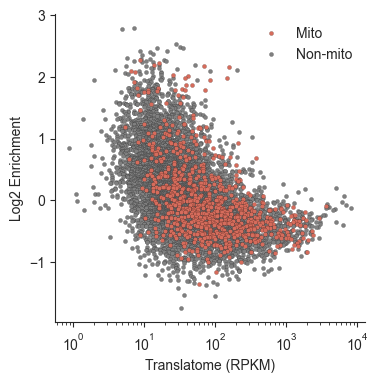

In [108]:
data = pd.read_csv(directory_path + 'gene_enrichment_list_threshold.csv')
x_value = str(group1) + '_RPKM'
y_value = 'Log2_ratio'

# Slice out x and y values
x = data[x_value]
y = data[y_value]

# data2 = data[data['Log2_ratio'] >= 1]
data2 = data


x_cyto = data2.loc[data2['localization'] != 'mitochondria', x_value]
y_cyto = data2.loc[data2['localization'] != 'mitochondria', y_value]

x_sec = data2.loc[data2['localization'] == 'secretome', x_value]
y_sec = data2.loc[data2['localization'] == 'secretome', y_value]

x_mito = data2.loc[data2['localization'] == 'mitochondria', x_value]
y_mito = data2.loc[data2['localization'] == 'mitochondria', y_value]

# pearson = round(pearsonr(x, y)[0],3)

plt.figure(figsize=(4, 4))

fig1 = plt.plot(x_cyto ,y_cyto, marker='o', color='grey',linestyle='none', markersize=3, mec = 'black', mew = 0.1)
# fig2 = plt.plot(x_sec , y_sec, marker='o', color='yellow',linestyle='none', markersize=3, mec = 'black', mew = 0.1)
fig2 = plt.plot(x_mito , y_mito, marker='o', color='#D66C5C',linestyle='none', markersize=3, mec = 'black', mew = 0.1)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on")

legend=ax.legend((fig2 + fig1), ['Mito', 'Non-mito'],prop={'size':10}, loc = 'upper right')
legend.get_frame().set_linewidth(0.0)

# # legend=plt.legend(["Pearson's r =" + str(pearson)], loc='lower right', prop={'size':10})

# plt.text(-1.5, 2.5, "$\mathregular{R^2}$ = " + str(pearson), fontsize=14, weight='bold')
plt.xlabel('Translatome (RPKM)',fontsize=10)
plt.ylabel('Log2 Enrichment',fontsize=10)


plt.xscale('log') 

# plt.plot(x_boundary, 2*x_boundary,color='black',linestyle='--',linewidth=1)
# plt.plot(x_boundary, 0.5*x_boundary,color='black',linestyle='--',linewidth=1)

# plt.savefig(directory_path + 'TOM22_scatterplot_all.jpg', dpi=300, bbox_inches = 'tight')


In [41]:
def three_nt_periodicity(group):
    end = 150
    codon_positions = range(1, end + 1)
    read_counts = {i: 0 for i in codon_positions}
    position_counts = {i: 0 for i in codon_positions}

    total_genes = 0
    p = p1 if group == group1 else p2
    total_reads = p1_Total_Reads if group == group1 else p2_Total_Reads

    for gene, data in p.items():
        cds_length = int(data.attrs['cds_length'])
        norm_factor = sum(data[1]) / cds_length

        if norm_factor >= 0.5:
            total_genes += 1
            for pos in codon_positions:
                if pos in data[0]:
                    index = data[0].tolist().index(pos)
                    nt_reads = data[1][index]
                    norm_reads = nt_reads / norm_factor / 3

                    read_counts[pos] += norm_reads
                    position_counts[pos] += 1

    # Calculate normalized read counts
    normalized_reads = {
        pos: read_counts[pos] / position_counts[pos]
        for pos in codon_positions if position_counts[pos] > 0
    }

    # Convert to DataFrame and save
    three_nt_df = pd.DataFrame.from_dict(normalized_reads, orient='index', columns=['normalized_read_count'])
    three_nt_df.index.name = 'codon'
    three_nt_df.to_csv(f'{directory_path}/three_nt_{group}.csv')

    return three_nt_df



(0.0, 150.0)

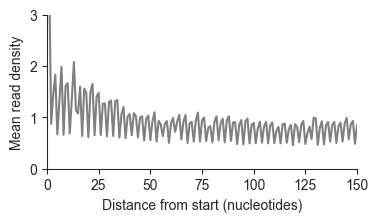

In [96]:
group = 'p1'
data = three_nt_periodicity(group)
x = data.index
y = data['normalized_read_count']

plt.figure(figsize=(4, 2))
plt.plot(x,y, color = 'grey')
plt.xlabel('Distance from start (nucleotides)')
plt.ylabel('Mean read density')

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on")

plt.ylim(0, 3)
plt.xlim(0, 150)


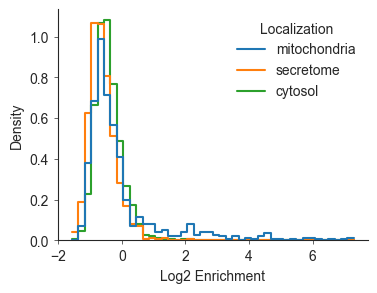

In [30]:
def assign_category(localization):
    return 'Mito' if localization == 'mitochondria' else 'Non-mito'

# Load data
data = pd.read_csv(f'{directory_path}gene_enrichment_list_threshold.csv')

# Assign categories using apply
data['mitochondrial?'] = data['localization'].apply(assign_category)

# Plot settings
x_value = 'Log2_ratio'
fig, ax = plt.subplots(figsize=(4, 3))

# Plot using seaborn
sns.histplot(data=data, x=x_value, binwidth=0.2, hue='localization',
             element="step", fill=False, stat="density", kde=False,
             common_norm=False, lw=1.5, legend=True)

# Style adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Density', fontsize=10)
ax.set_xlabel('Log2 Enrichment', fontsize=10)

ax.tick_params(axis="x", labelsize=10, width=0.5, length=3)
ax.tick_params(axis="y", labelsize=10, width=0.5, length=3)

# Customize legend
legend = ax.get_legend()
if legend:
    handles = legend.legend_handles
    legend.set_title('Localization')
    legend.get_frame().set_linewidth(0.0)


plt.show()


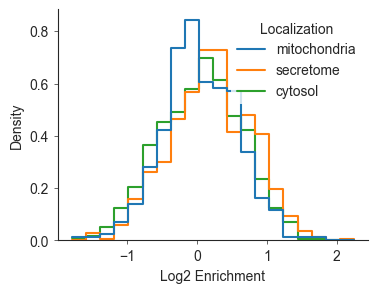

In [131]:
def assign_category(localization):
    return 'Mito' if localization == 'mitochondria' else 'Non-mito'

# Load data

data1 = pd.read_csv(f'./rep2/gene_enrichment_list_threshold.csv')
data2 = pd.read_csv(f'../Sequencing_data_20230831/rep1/gene_enrichment_list_threshold.csv')

data = pd.merge(data1, data2, on=['gene', 'localization', 'Length'], how='inner')
# Assign categories using apply
data['mitochondrial?'] = data['localization'].apply(assign_category)
data['Log2_Translatome'] = np.log2(data['p1_RPKM_y'] / data['p1_RPKM_x'])
# Plot settings
x_value = 'Log2_Translatome'
fig, ax = plt.subplots(figsize=(4, 3))

# Plot using seaborn
sns.histplot(data=data, x=x_value, binwidth=0.2, hue='localization',
             element="step", fill=False, stat="density", kde=False,
             common_norm=False, lw=1.5, legend=True)

# Style adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Density', fontsize=10)
ax.set_xlabel('Log2 Enrichment', fontsize=10)

ax.tick_params(axis="x", labelsize=10, width=0.5, length=3)
ax.tick_params(axis="y", labelsize=10, width=0.5, length=3)

# Customize legend
legend = ax.get_legend()
if legend:
    handles = legend.legend_handles
    legend.set_title('Localization')
    legend.get_frame().set_linewidth(0.0)


plt.show()


In [130]:
data

,gene,localization,Length,p1_count_x,p2_count_x,p1_RPKM_x,p2_RPKM_x,ratio_x,Log2_ratio_x,p1_norm_x,...,p1_count_y,p2_count_y,p1_RPKM_y,p2_RPKM_y,ratio_y,Log2_ratio_y,p1_norm_y,p2_norm_y,mitochondrial?,Log2_Translatome
0,PDPR,mitochondria,880,109,5493,5.555842,870.605487,156.700908,7.291870,0.123864,...,93,1299,9.584813,640.821028,66.857961,6.063027,0.105682,1.476136,Mito,1.725177
1,ACO2,mitochondria,781,1068,50425,61.337530,9005.116714,146.812511,7.197831,1.367478,...,672,7158,78.037184,3978.789245,50.985813,5.672024,0.860435,9.165173,Mito,1.272258
2,IARS2,mitochondria,1013,1659,70024,73.458660,9641.218893,131.246866,7.036139,1.637710,...,1331,16526,119.165890,7082.206379,59.431490,5.893156,1.313919,16.313919,Mito,1.622217
3,TRPM7,secretome,1895,241,9045,5.704451,665.723411,116.702441,6.866691,0.127177,...,229,7529,10.959976,1724.798469,157.372462,7.298039,0.120844,3.973087,Non-mito,1.921302
4,LARS2,mitochondria,904,857,25598,42.522467,3949.408689,92.878165,6.537268,0.948009,...,479,5179,48.056311,2487.068550,51.753214,5.693577,0.529867,5.728982,Mito,1.130139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,CDS2,secretome,446,788,100,79.249662,31.272285,0.394605,-1.341520,1.766816,...,558,51,113.470428,49.641580,0.437485,-1.192695,1.251121,0.114350,Non-mito,1.431810
3309,CD59,secretome,129,676,84,235.051511,90.820534,0.386386,-1.371887,5.240310,...,451,60,317.080973,201.916503,0.636798,-0.651092,3.496124,0.465116,Non-mito,1.348985
3310,SC5D,secretome,300,667,80,99.726515,37.193171,0.372952,-1.422939,2.223333,...,781,60,236.109320,86.824096,0.367728,-1.443288,2.603333,0.200000,Non-mito,2.367568
3311,TMEM179B,secretome,220,1125,131,229.369624,83.050660,0.362082,-1.465611,5.113636,...,480,68,197.880003,134.182694,0.678101,-0.560427,2.181818,0.309091,Non-mito,0.862712


/Users/zhuzikun/miniconda3/envs/ZZ/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhuzikun/miniconda3/envs/ZZ/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zhuzikun/miniconda3/envs/ZZ/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


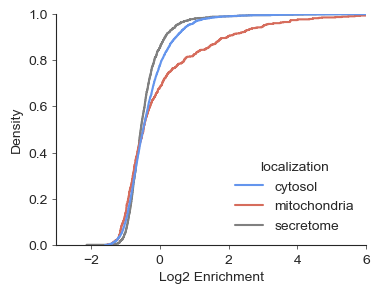

In [15]:
data = pd.read_csv(directory_path + 'gene_enrichment_list_threshold.csv')

x_value='Log2_ratio'

x = data[x_value]
x = x.tolist()


sec_x = data.loc[data['localization'] == 'secretome',x_value]
sec_x = sec_x.tolist()

cyto_x = data.loc[data['localization'] == 'cytosol',x_value]
cyto_x = cyto_x.tolist()

mito_x= data.loc[data['localization'] == 'mitochondria',x_value]
mito_x = mito_x.tolist()

fig, ax = plt.subplots(figsize=(4,3))

bins_width=[]
t=-2
while t <= 5:
    bins_width.append(t)
    t+=0.1

# sns.histplot(data = data, x = x_value, bins = bins_width, hue = 'localization', hue_order = ['mitochondria', 'secretome', 'cytosol'],
#              cumulative = True, element="step", stat="density", common_norm=False, palette = ['cornflowerblue', '#D66C5C', 'grey'],
#              legend = True, fill =False)

sns.ecdfplot(data = data, x = x_value, hue = 'localization',complementary=False, palette = ['cornflowerblue', '#D66C5C', 'grey'])
    
# sns.histplot(cyto_x ,color="grey",kde = True, label='Cytosolic', alpha = 1, stat="density")
# sns.histplot(cyto_x ,color="lightgrey",kde = True, label='Cytosolic', lw = 0, alpha = 0.7, fill = True, stat="density")

# sns.histplot(sec_x, color="#D66C5C",kde = True, label='IMPs', alpha = 0.5, stat="density")
# sns.histplot(mito_x,color="cornflowerblue",kde = True, label='mito', alpha = 0.5, stat="density")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Make a plot with labeled axes, etc

ax.set_ylabel('Density',fontsize=10)
ax.set_xlabel('Log2 Enrichment',fontsize=10)

ax.tick_params(bottom="on", left="on", width = 0.5)
ax.tick_params(axis="y", labelsize=10, width = 0.5, length = 3) 
ax.tick_params(axis="x", labelsize=10, width = 0.5, length = 3) 

legend = ax.get_legend()
legend.get_frame().set_linewidth(0.0)

# handles = legend.legend_handles
# legend.remove()
# legend_new = ax.legend(['Mitochondrial','ER', 'other',],loc = 'lower right')

ax.set_xlim(-3,6)
# ax.set_xticks(np.arange(-2, 3, step=1))

# ax.vlines(1, 0, 1, color = 'black', linewidth = 0.8, linestyle = '--')
# ax.set_yticks(np.arange(0, 150, step=30))

plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['pdf.fonttype'] = '42'
# plt.savefig(publish_directory_path  + 'TOM22_CDF_all.pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
def heatmap_start_codon():

    scores_dict = {}
    data = pd.read_csv(directory_path + '/Mito_gene_enrichment_list_threshold.csv')
    data = data[['Log2_ratio','SubMitoLocalization','gene', 'Length', 'UniProt', 'MTS?']].copy()

    for gene in data['gene'].unique():
        cache_filename = f"{directory_path}/genes/{gene}.pkl"
        if os.path.exists(cache_filename):
            with open(cache_filename, 'rb') as f:
                y_data = pickle.load(f)
        else:
            os.makedirs(os.path.=dirname(cache_filename), exist_ok=True)  # This line ensures the directory exists
            y_data = gene_enrichment(gene)
            if not y_data:  # Check if y3_data is empty or None, implying the gene does not exist
                print(f"Skipping {gene} as it does not exist.")
                data = data[data['gene'] != gene]
                continue  # Skip to the next iteration of the loop
            else:       
                with open(cache_filename, 'wb') as f:
                    pickle.dump(y_data, f)    
            
        y3_data = y_data[3]
        scores_dict[gene] = {i: np.log2(score) for i, score in enumerate(y3_data)}
    # Convert the scores dictionary into a DataFrame
    score_data = pd.DataFrame(scores_dict).transpose()

    # Concatenate the original data and the score data
    data.set_index('gene', inplace=True)

    data = pd.concat([data, score_data], axis=1)

    return data


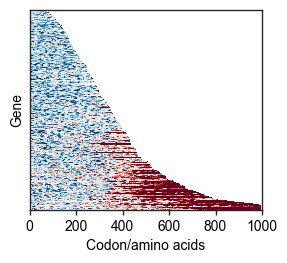

In [56]:
heatmap_df_mito = heatmap_start_codon()

df = heatmap_df_mito.copy()
df = df.iloc[:,:1000]
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'gene'})
# df.to_csv(directory_list[sample] + '/Mito_heatmap.csv', index= False)

df = df[df['MTS?'] == 'yes']
df = df.set_index('gene')
df = df.sort_values(by = ['Length'])
df = df.drop(columns = ['SubMitoLocalization','Length', 
                        'UniProt', 'MTS?'])
# df = df.iloc[350:400]
# df = df.tail(50)
# df = df.head(100)
nan_mask = np.isnan(df)
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad("white")

fig,ax1 = plt.subplots(figsize = (3,2.6))
ax1 = sns.heatmap(df, vmin = -2.5, vmax = 2.5, yticklabels = False, cbar_kws={"shrink": 0.15, 'aspect': 4}, 
                  cmap=cmap, mask=nan_mask, cbar = False)
# ax1 = sns.clustermap(df, vmin = -2.5, vmax = 2.5, yticklabels = False, cbar_kws={"shrink": 0.15, 'aspect': 4}, 
#                   cmap=cmap, mask=nan_mask, cbar = True)
# ax1.set_xlim(1, 700)
# ax1.set_xticks(np.arange(0, 600, 50))


for _, spine in ax1.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)  # Change the width of the spines

for label in ax1.get_yticklabels():
    label.set_size(5)

tick_locations = np.arange(0, 1100, 200)
ax1.set_xticks(tick_locations)
ax1.tick_params(width=1)  # Change the width of the ticks

labels = np.arange(0, 1100, 200)
ax1.set_xticklabels(labels, rotation = 0, color = 'black', size = 10)

ax1.set_xlabel('Codon/amino acids', color = 'black', size = 10)
ax1.set_ylabel('Gene', color = 'black', size = 10)

plt.rcParams['pdf.fonttype'] = '42'
# plt.savefig(publish_directory_path  + '/heatmap_noMTS_small.png', dpi=600, bbox_inches = 'tight')


In [97]:
# Helper function to get the path where results for a gene are saved
def get_nt_to_codon_path(gene, p_type, directory_path):
    filename = f"{gene}_{p_type}.pkl"
    return os.path.join(directory_path, "genes", filename)  # Added "genes" subdirectory

def cached_nt_to_codon(p_type, gene, directory_path):
    file_path = get_nt_to_codon_path(gene, p_type, directory_path)
    
    if os.path.exists(file_path):
        with open(file_path, "rb") as file:
            return pickle.load(file)
    
    # Ensure the directory exists before attempting to write
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # This line ensures the directory exists
    
    result = nt_to_codon(p_type, gene)
    with open(file_path, "wb") as file:
        pickle.dump(result, file)
    
    return result

def initialize_dict(codons, keys=None):
    if not keys:
        return {i: [] for i in codons}
    else:
        return {key: [] for key in keys}

def calculate_mean_and_CI(codon_dict, full_dict, mean_key, upper_key, lower_key, confidence_interval, codons):
    for i in codons:
        resampled_means = [np.nanmean(resample(codon_dict[i], n_samples=len(codon_dict[i]))) for _ in range(100)]
        full_dict[mean_key].append(np.nanmean(codon_dict[i]))
        
        lower_quantile = np.quantile(resampled_means, 0.5 * (1 - confidence_interval))
        upper_quantile = np.quantile(resampled_means, 1 - 0.5 * (1 - confidence_interval))
        
        full_dict[upper_key].append(lower_quantile)
        full_dict[lower_key].append(upper_quantile)

def metagene_start_codon(localization, end, directory_path):
    codons = list(range(1, end + 1))
    codon_dict1 = initialize_dict(codons)
    codon_dict2 = initialize_dict(codons)
    min_RPC = 0.25

    df = pd.read_csv(f'{directory_path}gene_enrichment_list.csv')
    df = df[df['localization'] == localization]
    df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    # df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    # df = df[df['Length'] >= 300]

    num = 0
    for _, row in df.iterrows():
        gene = row.iloc[0]
        codon_length = row['Length']
        p1_norm = row['p1_norm']
        p2_norm = row['p2_norm']
    
        Dict1 = cached_nt_to_codon('p1', gene, directory_path)
        Dict2 = cached_nt_to_codon('p2', gene, directory_path)
        
        num += 1
        
        for k in range(1, min(codon_length, end) + 1):
            codon_dict1[k].append(Dict1.get(k, 0.01) / p1_norm)
            codon_dict2[k].append(Dict2.get(k, 0.01) / p2_norm)

    confidence_interval = 0.95
    keys = ['mean1', 'CI_upper1', 'CI_lower1', 'mean2', 'CI_upper2', 'CI_lower2']
    full_dict = initialize_dict(keys)

    calculate_mean_and_CI(codon_dict1, full_dict, 'mean1', 'CI_upper1', 'CI_lower1', confidence_interval, codons)
    calculate_mean_and_CI(codon_dict2, full_dict, 'mean2', 'CI_upper2', 'CI_lower2', confidence_interval, codons)


    metagene_df = pd.DataFrame(full_dict)
    metagene_df.to_csv(f'{directory_path}{localization}_metagene_start_codon.csv', index=None)
    print(num)
    return full_dict

In [98]:
end = 600
localization = 'mitochondria'

meta_Dict = metagene_start_codon(localization, end, directory_path)


858


Text(0, 0.5, 'Ribosome density (AU')

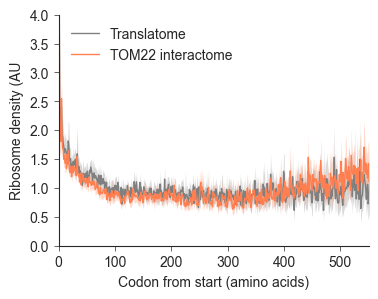

In [99]:
localization = 'mitochondria'

data = pd.read_csv(f'{directory_path}/{localization}_metagene_start_codon.csv') 

end = 600
x = range(1, end + 1) 

color1 = 'grey'
color2 = 'coral'
plt.figure(figsize = (4, 3))
plt.plot(x, data['mean1'], color = color1, linewidth = 1)
plt.plot(x, data['mean2'], color = color2, linewidth = 1)
plt.fill_between(x, data['CI_upper1'], data['CI_lower1'], color = color1, linewidth=0.0, alpha= 0.3)
plt.fill_between(x, data['CI_upper2'], data['CI_lower2'], color = color2, linewidth=0.0, alpha= 0.3)
# plt.plot(x, data['median_ratios'], color = 'black', linewidth = 1)
# plt.fill_between(x, data['CI_lower_ratios'], data['CI_upper_ratios'], color = 'black', linewidth=0.0, alpha= 0.3)

plt.xlim(0, 550)

plt.ylim(0,4)

legend = plt.legend(['Translatome','TOM22 interactome'], loc = 'upper left')
legend.get_frame().set_linewidth(0.0)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on", width = 0.5)
# Make a plot with labeled axes, etc


plt.xlabel('Codon from start (amino acids)')
plt.ylabel('Ribosome density (AU')

# plt.savefig(publish_directory_path + 'metagene_start_HSP70.pdf', dpi=300, bbox_inches = 'tight')


Text(0, 0.5, 'Ribosome density (AU')

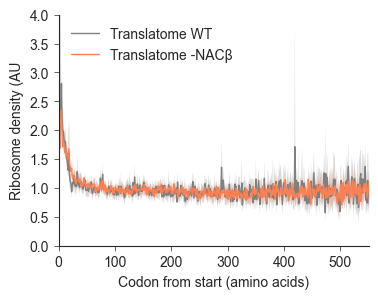

In [103]:
localization = 'mitochondria'

data1 = pd.read_csv(f'./rep1/{localization}_metagene_start_codon.csv') 
data2 = pd.read_csv(f'../Sequencing_data_20230831/rep2/{localization}_metagene_start_codon.csv') 

end = 600
x = range(1, end + 1) 

color1 = 'grey'
color2 = 'coral'
plt.figure(figsize = (4, 3))
plt.plot(x, data1['mean1'], color = color1, linewidth = 1)
plt.plot(x, data2['mean1'], color = color2, linewidth = 1)
plt.fill_between(x, data1['CI_upper1'], data1['CI_lower1'], color = color1, linewidth=0.0, alpha= 0.3)
plt.fill_between(x, data2['CI_upper1'], data2['CI_lower1'], color = color2, linewidth=0.0, alpha= 0.3)
# plt.plot(x, data['median_ratios'], color = 'black', linewidth = 1)
# plt.fill_between(x, data['CI_lower_ratios'], data['CI_upper_ratios'], color = 'black', linewidth=0.0, alpha= 0.3)

plt.xlim(0, 550)

plt.ylim(0,4)

legend = plt.legend(['Translatome WT','Translatome -NACβ'], loc = 'upper left')
legend.get_frame().set_linewidth(0.0)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on", width = 0.5)
# Make a plot with labeled axes, etc


plt.xlabel('Codon from start (amino acids)')
plt.ylabel('Ribosome density (AU')

# plt.savefig(publish_directory_path + 'metagene_start_HSP70.pdf', dpi=300, bbox_inches = 'tight')


In [19]:
def metagene_stop_codon(localization, end, directory_path):
    # Initialize codons in reverse
    codons = list(range(-1, -end - 1, -1))
    codon_dict1 = initialize_dict(codons)
    codon_dict2 = initialize_dict(codons)
    min_RPC = 0.25

    df = pd.read_csv(f'{directory_path}/gene_enrichment_list.csv')
    df = df[df['localization'] == localization]
    df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    df = df[df['Length'] >= 300]
    
    num = 0
    for _, row in df.iterrows():
        gene = row.iloc[0]
        codon_length = row['Length']
        p1_norm = row['p1_norm']
        p2_norm = row['p2_norm']
    
        Dict1 = cached_nt_to_codon('p1', gene, directory_path)
        Dict2 = cached_nt_to_codon('p2', gene, directory_path)
        
        num += 1
        
        # Adjust the loop to fetch codon values from the end of the gene backwards
        for k in codons:
            reverse_position = codon_length + k
            if reverse_position > 0:
                codon_dict1[k].append(Dict1.get(reverse_position, 0.01) / p1_norm)
                codon_dict2[k].append(Dict2.get(reverse_position, 0.01) / p2_norm)

    confidence_interval = 0.95
    keys = ['mean1', 'CI_upper1', 'CI_lower1', 'mean2', 'CI_upper2', 'CI_lower2']
    full_dict = initialize_dict(keys)

    calculate_mean_and_CI(codon_dict1, full_dict, 'mean1', 'CI_upper1', 'CI_lower1', confidence_interval, codons)
    calculate_mean_and_CI(codon_dict2, full_dict, 'mean2', 'CI_upper2', 'CI_lower2', confidence_interval, codons)

    # Save the result with a filename that mentions it's calculated from the stop codon
    metagene_df = pd.DataFrame(full_dict)
    metagene_df.to_csv(f'{directory_path}/{localization}_metagene_stop_codon.csv', index=None)
    print(num)
    return full_dict


In [20]:
end = 600
localization = 'mitochondria'

meta_stop_Dict = metagene_stop_codon(localization, end,directory_path)


378


Text(0, 0.5, 'Mean read density')

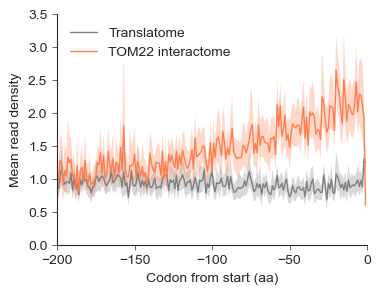

In [21]:
data = pd.read_csv(f'{directory_path}/{localization}_metagene_stop_codon.csv') 

end = 600
x = range(-1, -end - 1, -1)

plt.figure(figsize = (4, 3))
plt.plot(x, data['mean1'], color = 'grey', linewidth = 1)
plt.plot(x, data['mean2'], color = 'coral', linewidth = 1)
plt.fill_between(x, data['CI_upper1'], data['CI_lower1'], color = 'grey', linewidth=0.0, alpha= 0.3)
plt.fill_between(x, data['CI_upper2'], data['CI_lower2'], color = 'coral', linewidth=0.0, alpha= 0.3)
# plt.plot(x, data['median_ratios'], color = 'black', linewidth = 1)
# plt.fill_between(x, data['CI_lower_ratios'], data['CI_upper_ratios'], color = 'black', linewidth=0.0, alpha= 0.3)

plt.xlim(-200, 0)

plt.ylim(0,3.5)

legend = plt.legend(['Translatome','TOM22 interactome'], loc = 'upper left')
legend.get_frame().set_linewidth(0.0)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on", width = 0.5)
# Make a plot with labeled axes, etc


plt.xlabel('Codon from start (aa)')
plt.ylabel('Mean read density')

# plt.savefig(directory_path + 'metagene_start_codon.jpg', dpi=300, bbox_inches = 'tight')



In [43]:
def detect_peaks(threshold=2.5, min_consecutive=10):
    """
    Detects peaks in gene enrichment data based on a threshold and minimum consecutive values.
    
    Args:
        directory_path (str): The directory where the data and output will be stored.
        df (pd.DataFrame): The dataframe containing the gene enrichment data.
        threshold (float): The threshold value above which peaks are considered.
        min_consecutive (int): The minimum number of consecutive values above the threshold to form a peak.
        
    Returns:
        dict: A dictionary where keys are gene names and values are lists of tuples representing peak ranges.
        pd.DataFrame: The DataFrame with peak detection results, including 'peak?' and 'peak_start' columns.
    """
    peaks = {}
    min_RPC = 0.25

    df = pd.read_csv(f'{directory_path}/Mito_gene_enrichment_list.csv')  # Load the data once

    # Filter based on minimum RPC values
    df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    genelist = df['gene']
    
    # Save the filtered data
    df.to_csv(f'{directory_path}/Mito_gene_enrichment_list_threshold.csv', index=False)

    # Process each gene for peak detection
    for gene in genelist:
        x1, y1, y2, y3, y4 = gene_enrichment(gene)
        
        peak_ranges = []
        consecutive_count = 0
        start_index = None

        # Identify peaks based on the threshold and consecutive counts
        for i, score in enumerate(y3):
            if 5 < i < len(y3) - 5:  # Avoid edges for peak detection
                if score >= threshold:
                    consecutive_count += 1
                    if start_index is None:
                        start_index = i
                else:
                    if consecutive_count >= min_consecutive:
                        peak_ranges.append((start_index, i - 1))
                    consecutive_count = 0
                    start_index = None

        # Append the last peak if it ends at the end of the list
        if consecutive_count >= min_consecutive:
            peak_ranges.append((start_index, len(y3) - 1))

        if peak_ranges:
            peaks[gene] = peak_ranges

    # Save the detected peaks to a JSON file
    with open(f'{directory_path}/peaks.json', 'w') as outfile:
        json.dump(peaks, outfile)

    # Annotate df with peak information
    genes_with_peaks = peaks.keys()
    print(len(genes_with_peaks))
    
    df.loc[:, 'peak?'] = df['gene'].apply(lambda x: 'yes' if x in genes_with_peaks else 'no')
    df.loc[:, 'peak_start'] = df['gene'].apply(lambda x: peaks[x][0][0] if x in genes_with_peaks else ' ')


    # Save the result with the peak columns
    df.to_csv(f'{directory_path}/Mito_peak_detection_list.csv', index=False)

    return df

# Example usage
df = detect_peaks(2.5, 15)


184


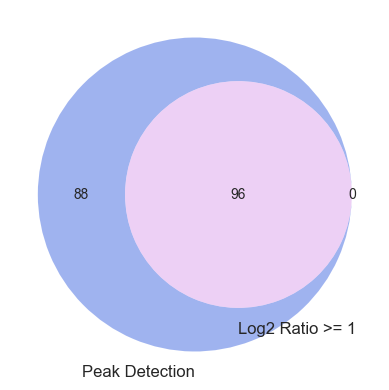

In [44]:
# Load the Mito_peak_detection_list.csv once
df = pd.read_csv(f'{directory_path}/Mito_peak_detection_list.csv')

# Filter genes for Peak Detection and Log2 Ratio
gene_PD = set(df.loc[df['peak?'] == 'yes', 'gene'])
gene_TE = set(df.loc[df['Log2_ratio'] >= 1, 'gene'])

# Create a Venn diagram
venn2([gene_PD, gene_TE], set_labels=('Peak Detection', 'Log2 Ratio >= 1'),
     set_colors=('royalblue', 'salmon'), alpha=0.5)

# Display the Venn diagram
plt.show()


In [28]:
# Helper function to get the path where results for a gene are saved
def get_nt_to_codon_path(gene, p_type, directory_path):
    filename = f"{gene}_{p_type}.pkl"
    return os.path.join(directory_path, "genes", filename)  # Added "genes" subdirectory

def cached_nt_to_codon(p_type, gene, directory_path):
    file_path = get_nt_to_codon_path(gene, p_type, directory_path)
    
    if os.path.exists(file_path):
        with open(file_path, "rb") as file:
            return pickle.load(file)
    
    # Ensure the directory exists before attempting to write
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # This line ensures the directory exists
    
    result = nt_to_codon(p_type, gene)
    with open(file_path, "wb") as file:
        pickle.dump(result, file)
    
    return result

def initialize_dict(codons, keys=None):
    if not keys:
        return {i: [] for i in codons}
    else:
        return {key: [] for key in keys}

def calculate_mean_and_CI(codon_dict, full_dict, mean_key, upper_key, lower_key, confidence_interval, codons):
    for i in codons:
        resampled_means = [np.nanmean(resample(codon_dict[i], n_samples=len(codon_dict[i]))) for _ in range(100)]
        full_dict[mean_key].append(np.nanmean(codon_dict[i]))
        
        lower_quantile = np.quantile(resampled_means, 0.5 * (1 - confidence_interval))
        upper_quantile = np.quantile(resampled_means, 1 - 0.5 * (1 - confidence_interval))
        
        full_dict[upper_key].append(lower_quantile)
        full_dict[lower_key].append(upper_quantile)


def metagene_start_codon_cotranslational(localization, end, directory_path):

    reads_norm = p1_Total_Reads/p2_Total_Reads

    codons = list(range(1, end + 1))
    codon_dict1 = initialize_dict(codons)
    codon_dict2 = initialize_dict(codons)
    codon_dict3 = initialize_dict(codons)
    min_RPC = 0.25

    df = pd.read_csv(f'{directory_path}/gene_enrichment_list.csv')
    df = df[df['localization'] == localization]
    df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]
    # df = df[(df['p1_norm'] >= min_RPC) | (df['p2_norm'] >= min_RPC)]

    # df = df[df['Length'] >= 300]
    
    df_peak = pd.read_csv(f'{directory_path}/Mito_peak_detection_list.csv')  # Load the data once
    genelist = df_peak[df_peak['peak?'] == 'yes']['gene'].tolist()

    num = 0
    for _, row in df.iterrows():
        gene = row.iloc[0]
        if gene in genelist:
            codon_length = row['Length']
            p1_norm = row['p1_norm']
            p2_norm = row['p2_norm']

            ratio = row['ratio']
            Dict1 = cached_nt_to_codon('p1', gene, directory_path)
            Dict2 = cached_nt_to_codon('p2', gene, directory_path)
            
            num += 1
            
            for k in range(1, min(codon_length, end) + 1):
                read1 = Dict1.get(k, 0.01)
                read2 = Dict2.get(k, 0.01)
                codon_dict1[k].append(read1/p1_norm)
                codon_dict2[k].append(read2/p2_norm)
                codon_dict3[k].append(np.log2(read2/read1*reads_norm/ratio))

    confidence_interval = 0.95
    keys = ['mean1', 'CI_upper1', 'CI_lower1', 'mean2', 'CI_upper2', 'CI_lower2', 'mean3', 'CI_upper3', 'CI_lower3']
    full_dict = initialize_dict(keys)

    calculate_mean_and_CI(codon_dict1, full_dict, 'mean1', 'CI_upper1', 'CI_lower1', confidence_interval, codons)
    calculate_mean_and_CI(codon_dict2, full_dict, 'mean2', 'CI_upper2', 'CI_lower2', confidence_interval, codons)
    calculate_mean_and_CI(codon_dict3, full_dict, 'mean3', 'CI_upper3', 'CI_lower3', confidence_interval, codons)


    metagene_df = pd.DataFrame(full_dict)
    metagene_df.to_csv(f'{directory_path}/{localization}_metagene_start_codon_cotranslational.csv', index=None)
    print(num)
    return full_dict

In [29]:
end = 600
localization = 'mitochondria'

meta_Dict = metagene_start_codon_cotranslational(localization, end, directory_path)


184


Text(0, 0.5, 'Mean normailized Log2 enrichment')

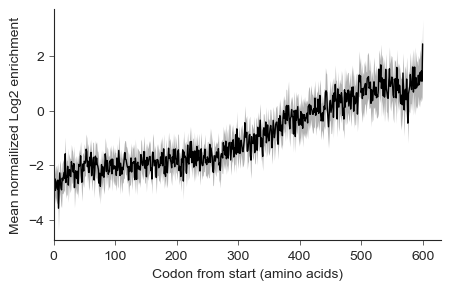

In [30]:
localization = 'mitochondria'

data = pd.read_csv(f'{directory_path}/{localization}_metagene_start_codon_cotranslational.csv') 

end = 600
x = range(1, end + 1) 

color1 = 'grey'
color2 = 'coral'
plt.figure(figsize = (5, 3))
# plt.plot(x, data['mean1'], color = color1, linewidth = 1)
# plt.plot(x, data['mean2'], color = color2, linewidth = 1)
# plt.fill_between(x, data['CI_upper1'], data['CI_lower1'], color = color1, linewidth=0.0, alpha= 0.3)
# plt.fill_between(x, data['CI_upper2'], data['CI_lower2'], color = color2, linewidth=0.0, alpha= 0.3)
plt.plot(x, data['mean3'], color = 'black', linewidth = 1)
plt.fill_between(x, data['CI_lower3'], data['CI_upper3'], color = 'black', linewidth=0.0, alpha= 0.3)

plt.xlim(0, )

# plt.ylim(-3,3)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom="on", left="on", width = 0.5)
# Make a plot with labeled axes, etc


plt.xlabel('Codon from start (amino acids)')
plt.ylabel('Mean normailized Log2 enrichment')

# plt.savefig(publish_directory_path + 'metagene_start_HSP70.pdf', dpi=300, bbox_inches = 'tight')
